# Task Overview and Dataset

Our task is to classify a patient as either having diabetes (class 1) or no diabetes (class 0).

We use **Pima Indians Diabetes Database** which is available on <a href="http://kaggle.com">Kaggle.com</a> (You can view and download the dataset from this <a href="https://www.kaggle.com/uciml/pima-indians-diabetes-database">link</a>).

In [4]:
import pandas as pd

data = pd.read_csv('data/diabetes.csv')

# data.head()

# Input and Output

In [3]:
data_input = data.drop(columns=['Outcome'])
data_output = data['Outcome']

# Splitting Dataset to (Train - Validation - Test)

In [7]:
from sklearn.model_selection import train_test_split

In [292]:
# Getting test data
X, X_test, y, y_test = train_test_split(
    data_input, 
    data_output, 
    test_size=0.2, 
    random_state=1
)

# Getting train and val data
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=1
)

In [293]:
print('Train size =', X_train.shape[0])
print('Val size =', X_val.shape[0])
print('Test size =', X_test.shape[0])

Train size = 411
Val size = 203
Test size = 154


# Feature Scaling

In [294]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [295]:
import pickle

with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Helper function: Evaluate Classifier

In [296]:
from sklearn.metrics import accuracy_score

'''
    Calculate and return training accuracy 
    and validation accuracy of given classifier
    on given training and validation data
'''
def eval_classifier(clf, X_train, y_train, X_val, y_val):
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    print(clf.__class__.__name__)
    print('acc train:', acc_train)
    print('acc val:', acc_val)
    print('----------------------------')
    return acc_train, acc_val

# Voting Classifier

In [297]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [298]:
tree_clf = DecisionTreeClassifier(random_state=1)
logistic_clf = LogisticRegression(random_state=1)
svc_clf = SVC(random_state=1)

estimators = [
    ('tree', tree_clf),
    ('logistic', logistic_clf),
    ('svc', svc_clf),
]

voting_clf = VotingClassifier(estimators)

In [299]:
all_estimators = estimators + [('voting', voting_clf)]

results = {
    'model': [],
    'acc train': [],
    'acc val': []
}

for (name, clf) in all_estimators:
    acc_train, acc_val = eval_classifier(
        clf, X_train_scaled, y_train, X_val_scaled, y_val
    )
    results['model'].append(name)
    results['acc train'].append(acc_train)
    results['acc val'].append(acc_val)

DecisionTreeClassifier
acc train: 1.0
acc val: 0.6748768472906403
----------------------------
LogisticRegression
acc train: 0.7761557177615572
acc val: 0.7733990147783252
----------------------------
SVC
acc train: 0.8272506082725061
acc val: 0.7487684729064039
----------------------------
VotingClassifier
acc train: 0.8467153284671532
acc val: 0.7586206896551724
----------------------------


# Bagging

In [300]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(
    LogisticRegression(random_state=1), n_estimators=100,
    max_samples=0.75, bootstrap=True, random_state=1, n_jobs=-1
)

acc_train_bag, acc_val_bag = eval_classifier(
    bagging_clf, X_train_scaled, y_train, X_val_scaled, y_val
)

BaggingClassifier
acc train: 0.7737226277372263
acc val: 0.7832512315270936
----------------------------


# Random Forest

In [301]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=1)

acc_train_rf, acc_val_rf = eval_classifier(
    rf_clf, X_train_scaled, y_train, X_val_scaled, y_val
)

RandomForestClassifier
acc train: 0.8223844282238443
acc val: 0.7389162561576355
----------------------------


# Extremely Random Trees (Extra-Trees)

In [302]:
from sklearn.ensemble import ExtraTreesClassifier

ex_clf = ExtraTreesClassifier(n_estimators=100, max_depth=4, random_state=1)

acc_train_ex, acc_val_ex = eval_classifier(
    ex_clf, X_train_scaled, y_train, X_val_scaled, y_val
)

ExtraTreesClassifier
acc train: 0.7566909975669099
acc val: 0.7142857142857143
----------------------------


# Adaptive Boosting

In [303]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, min_samples_leaf=50, random_state=1), 
    n_estimators=500,
    learning_rate=0.05,
    random_state=1
)

acc_train_ada, acc_val_ada = eval_classifier(
    ada_clf, X_train_scaled, y_train, X_val_scaled, y_val
)

AdaBoostClassifier
acc train: 0.7883211678832117
acc val: 0.7438423645320197
----------------------------


# Gradient Boosting

In [304]:
from sklearn.ensemble import GradientBoostingClassifier

gbct_clf = GradientBoostingClassifier(max_depth=1, n_estimators=500, learning_rate=0.05, random_state=1)

acc_train_gbct, acc_val_gbct = eval_classifier(
    gbct_clf, X_train_scaled, y_train, X_val_scaled, y_val
)

GradientBoostingClassifier
acc train: 0.8272506082725061
acc val: 0.7487684729064039
----------------------------


# Comparing results

In [305]:
final_results = {
    'model': [],
    'acc train': [],
    'acc val': []
}

final_results['model'] = results['model'] + ['bagging', 'random forest', 'extra trees', 'adaboost', 'gbct']
final_results['acc train'] = results['acc train'] + [acc_train_bag, acc_train_rf, acc_train_ex, acc_train_ada, acc_train_gbct]
final_results['acc val'] = results['acc val'] + [acc_val_bag, acc_val_rf, acc_val_ex, acc_val_ada, acc_val_gbct]

In [307]:
final_results_df = pd.DataFrame(final_results)

final_results_df.sort_values(by='acc val', ascending=False, ignore_index=True, inplace=True)

final_results_df

,model,acc train,acc val
0,bagging,0.773723,0.783251
1,logistic,0.776156,0.773399
2,voting,0.846715,0.758621
3,svc,0.827251,0.748768
4,gbct,0.827251,0.748768
5,adaboost,0.788321,0.743842
6,random forest,0.822384,0.738916
7,extra trees,0.756691,0.714286
8,tree,1.000000,0.674877


In [308]:
final_results_df.to_csv('results.csv')

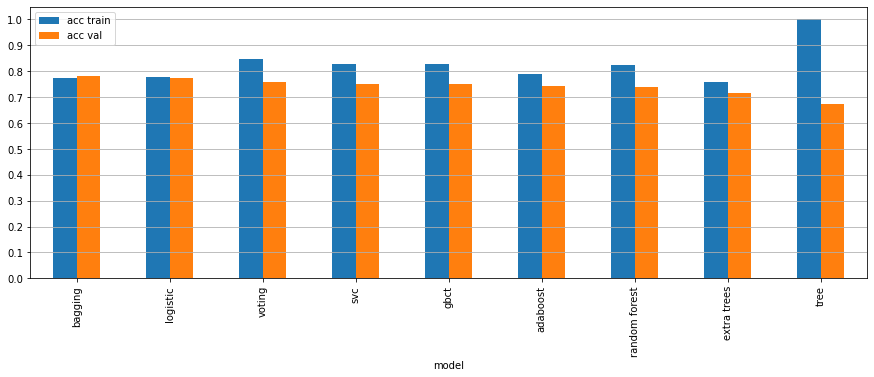

In [309]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

final_results_df.plot.bar(x='model', y=['acc train', 'acc val'], figsize=(15,5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y')
plt.show()

# Testing

In [310]:
bagging_clf = BaggingClassifier(
    LogisticRegression(random_state=1), n_estimators=100,
    max_samples=0.75, bootstrap=True, random_state=1, n_jobs=-1
)

bagging_clf.fit(X_train_scaled, y_train)

BaggingClassifier(base_estimator=LogisticRegression(random_state=1),
                  max_samples=0.75, n_estimators=100, n_jobs=-1,
                  random_state=1)

In [311]:
y_pred_test = bagging_clf.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_test))

0.7922077922077922


# Save model

In [312]:
import pickle

with open('saved-model.pickle', 'wb') as f:
    pickle.dump(bagging_clf, f)

# During inference time

In [313]:
import pickle

with open('saved-model.pickle', 'rb') as f:
    my_model = pickle.load(f)

with open('scaler.pickle', 'rb') as f:
    my_scaler = pickle.load(f)

In [332]:
# example input
x = data_input.iloc[0]
x_scaled = my_scaler.transform([x])

In [333]:
y = my_model.predict(x_scaled)

In [334]:
print(y[0])

1
